# TAREITA CIMF

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
import numpy as np
import datetime

In [218]:
nfile= '/content/qc00000260_chirinos.txt'
stn=nfile[-12:-4]
stn
# mat= np.loadtxt(nfile, dtype={'names': ('anio', 'mes', 'dia', 'pp', 'tmax', 'tmin'),
#                      'formats': ('i4', 'i4', 'i4', 'f4', 'f4', 'f4')})
#mat.ndim
#mat.shape
#np.reshape(mat,(row,col))

'chirinos'

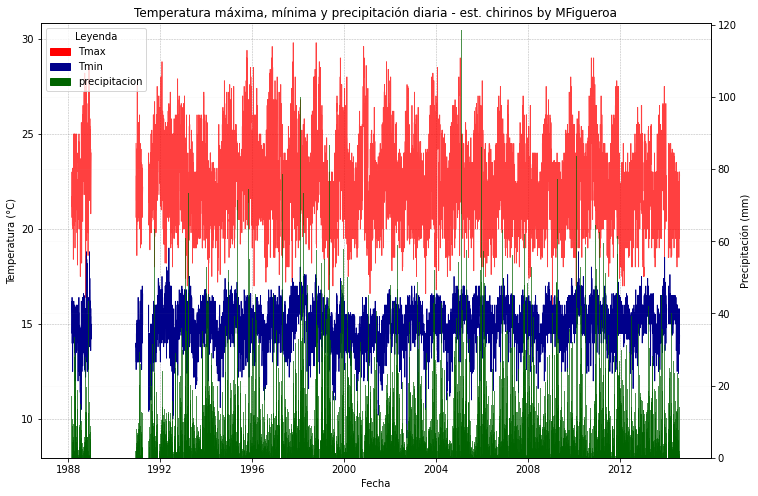

In [219]:
# GUIA> https://stackoverflow.com/questions/49975878/how-to-plot-day-and-month
#       https://www.analyticslane.com/2018/06/29/eliminar-filas-o-columnas-con-valores-nulos-en-python/
data = pd.read_csv(nfile, sep=" ", header=None, na_values= -99.9)

# names required
data.columns = ['year', 'month', 'day', 'pp', 'tmax', 'tmin']
data['fecha']= pd.to_datetime(data[['year','month','day']]) # puede ser un dict tbn
#data['fecha']= pd.to_datetime((data.Y*10000+data.M*100+data.D).apply(str),format='%Y%m%d')
#data['fecha']= pd.to_datetime(data.Y*10000+data.M*100+data.D,format='%Y%m%d')

#data[['pp','tmax','tmin']].where(data[['pp','tmax','tmin']] < -1)
#data[['pp','tmax','tmin']].mask(data[['pp','tmax','tmin']] < 0, 0)

#Vemos el tipo de objeto de cada columna
data.dtypes

data[data.pp<0]= np.nan
#data.dropna(axis=0, subset=['pp'])

# data.tmax[data.tmax==-99.9]=np.nan
# data.tmin[data.tmin==-99.9]= np.nan

data = data.set_index('fecha') #data.set_index('fecha', inplace=True)

def figurita(data, nomit=True, bar_width=15, stn=stn, **kwargs):
  fig = plt.figure(figsize=(12,8)) # ax= plt.gca()
  ax = fig.add_subplot(111)

  ax2 = ax.twinx()
  # align the twinx axis
  #ax2.set_yticks(ax.get_yticks())
  #yinf, ysup = ax.get_ylim()
  ax2.set_ylim([0, data.pp.max()+2])

  ax.plot(data.tmax, 'r', linewidth=0.8, alpha=0.75)
  ax.plot(data.tmin, 'darkblue', linewidth=0.8)

  if nomit:
    t=[i for i in list(data.index.tolist())]
    #ax.xaxis.set_major_locator(mdates.YearLocator(4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  else:
    t=np.arange(len(data.pp))
  ax2.bar(t,data.pp, color='darkgreen', label='Precipitacion', width=bar_width, bottom=0, alpha=0.7)
  
  #ax.legend(loc=1)

  ax.grid(color='gray', alpha=0.6, linestyle='dashed', linewidth=0.5)
  ax2.grid(alpha=0.05)
  ax.set_ylabel('Temperatura (°C)')
  ax.set_xlabel('Fecha')
  ax2.set_ylabel('Precipitación (mm)')
  ax.set_title('Temperatura máxima, mínima y precipitación diaria - est. '+stn+' by MFigueroa')

  legend_elements = [
                    Patch(facecolor='r', edgecolor='r', label='Tmax'),
                    Patch(facecolor='darkblue', edgecolor='darkblue', label='Tmin'),
                    Patch(facecolor='darkgreen', edgecolor='darkgreen', label='precipitacion'), #darkgreen
                    ]
  ax.legend(handles=legend_elements, loc="upper left", title='Leyenda')

figurita(data)

# # vemos que no hay data de tmax
# sum(1 for i in data.tmax if i > -99)

In [220]:
data= data.drop(['year','month','day'],axis=1)
data[['pp','tmax','tmin']].describe().T

count       mean       std   min   25%   50%   75%    max
pp    8797.0   3.704391  7.818714   0.0   0.0   0.4   4.0  118.5
tmax  8780.0  22.593292  2.114900  16.0  21.0  22.5  24.0   29.8
tmin  8782.0  15.034087  1.056735   9.0  14.5  15.0  15.8   19.0

In [221]:
#data.head(5)
countbyaniomes= data.groupby(by=[data.index.year,data.index.month]).count()
for col in data.columns:
  print(col,type(col))
#  countbyaniomes= data[col].groupby(by=[data.index.year,data.index.month]).count()
  print(len(countbyaniomes[col][(countbyaniomes[col]<15) & (countbyaniomes[col]>0)]))
  if len(countbyaniomes[col][(countbyaniomes[col]<15) & (countbyaniomes[col]>0)]) == 0:
    print('No hay de que preocuparse')
  else:
    print('changos! tienes q add : func para volver nan a los valores dentro de tal mes "O" al promedio o suma volverlo nan')
#  countbyaniomes[col][(countbyaniomes[col]<15) & (countbyaniomes[col]>0)]#.iloc[12:45]


pp <class 'str'>
0
No hay de que preocuparse
tmax <class 'str'>
0
No hay de que preocuparse
tmin <class 'str'>
0
No hay de que preocuparse


In [222]:
#data_mes1= data[['tmax','tmin']].groupby(by=[data.index.year, data.index.month]).mean()
data_mes1= data[['tmax','tmin']].groupby(pd.Grouper(freq='MS')).median()
data_mes2= data.pp.groupby(pd.Grouper(freq='MS')).sum()
#data_mes2=data.resample('M', on='fecha').sum()

data_mes=pd.DataFrame(data_mes2)
data_mes= data_mes.assign(**{'tmax': data_mes1.tmax, 'tmin': data_mes1.tmin})

data_mes.tail(10)

pp  tmax  tmin
fecha                         
2013-10-01  158.60  23.5  15.8
2013-11-01   12.50  24.5  16.0
2013-12-01  113.90  22.5  16.0
2014-01-01    0.00   NaN   NaN
2014-02-01  133.23  20.5  15.7
2014-03-01  177.20  21.4  15.6
2014-04-01   97.00  22.0  15.5
2014-05-01  107.80  21.5  16.0
2014-06-01  128.70  21.5  15.0
2014-07-01   66.80  21.5  14.6

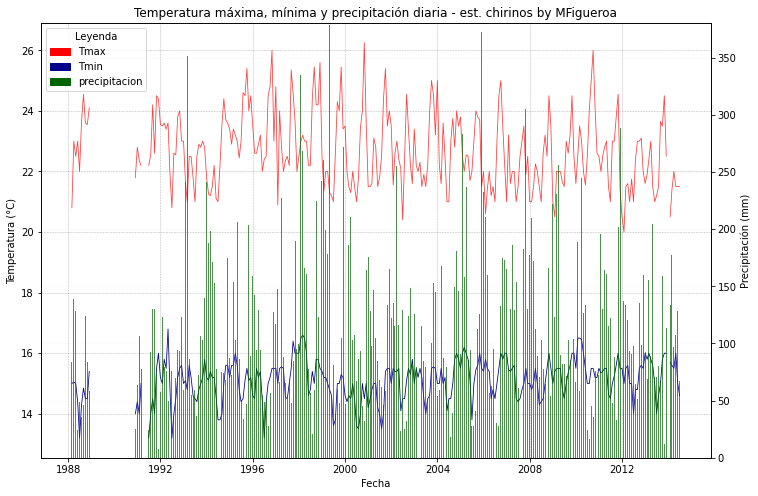

In [223]:
figurita(data_mes)

Text(0.5, 1.0, 'Climograma de la estación chirinos')

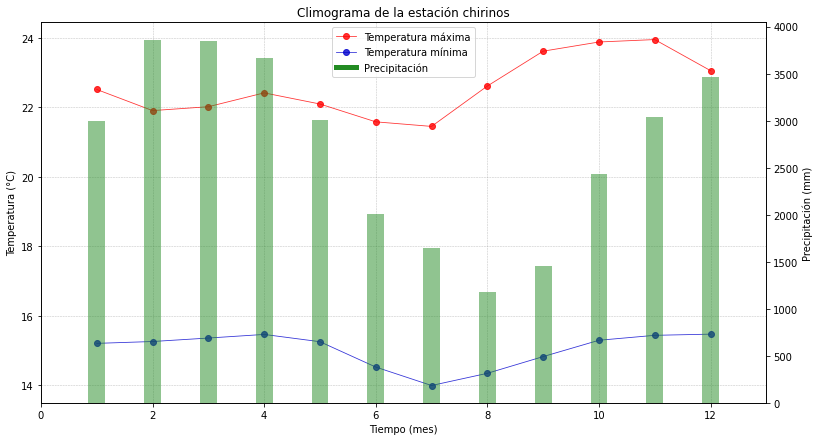

In [224]:
# climograma
data_climo1= data[['tmax','tmin']].groupby(by=[data.index.month]).mean()
data_climo2= data[['pp']].groupby(by=[data.index.month]).sum()
data_climo=pd.DataFrame(data_climo2)
data_climo= data_climo.assign(**{'tmax': data_climo1.tmax, 'tmin': data_climo1.tmin})


#Gráficas de la normal mensual
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
#----------------
ax.plot(data_climo['tmax'],marker='o', linewidth=0.8, color='red',label="Temperatura máxima", alpha=0.8)
ax.plot(data_climo['tmin'],marker='o', linewidth=0.8, color='mediumblue',label="Temperatura mínima", alpha=0.8)
ax2.bar(np.arange(1,13,1),data_climo['pp'], width = 0.3, color='forestgreen', alpha=0.5)
ax.plot(np.nan,'forestgreen', label = 'Precipitación', linewidth=5) 
ax.legend(loc='upper center')
#----------------
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
ax.set_xlim(0,13)
ax.set_ylabel('Temperatura (°C)')
ax.set_xlabel('Tiempo (mes)')
ax2.set_ylabel('Precipitación (mm)')
ax.set_title('Climograma de la estación '+ stn)

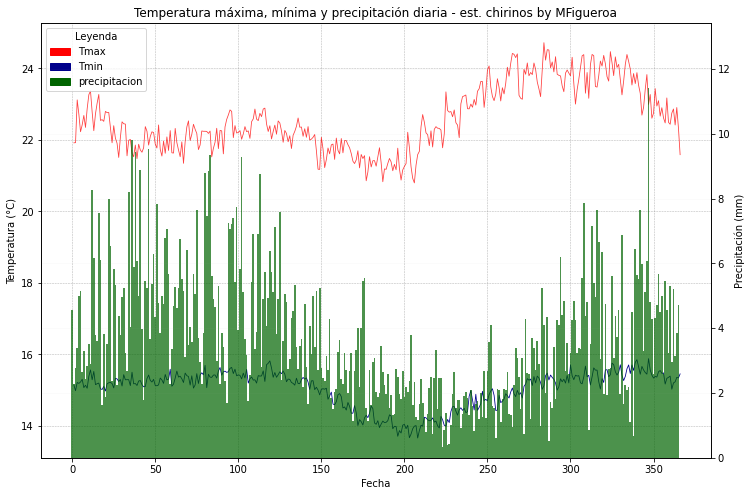

In [226]:
data_dayofyy1= data[['tmax','tmin']].groupby(by=[data.index.dayofyear]).mean()
data_dayofyy2= data[['pp']].groupby(by=[data.index.dayofyear]).mean()
data_dayofyy=pd.DataFrame(data_dayofyy2)
data_dayofyy= data_dayofyy.assign(**{'tmax': data_dayofyy1.tmax, 'tmin': data_dayofyy1.tmin})

figurita(data_dayofyy, nomit=False, bar_width=1)